# Predicting drug-target interaction

In this tuorial, we will go through how to run a GraphDTA model for compound-protein affinity prediction. In particular, we will demonstrate to train, evaluate and inference the GraphDTA model using scripts in folder `apps/drug_target_interaction/graph_dta/`.

# GraphDTA

**GraphDTA** represents compound drugs as graphs and uses graph neural networks to predict drug-target affinity. Specifically, the graph is converted from SMILES using RDKit, and passed through variants of graph neural network to extract its representation. For protein, the amino acid sequence is first embeded to an array of vectors, then sequence convolution is applied to get the protein representation. Finally, the combined representations of the compound drug and the protein is feeded into a feedforward network to regress the affinity measurement, such as Kd, Ki, KIBA, etc.

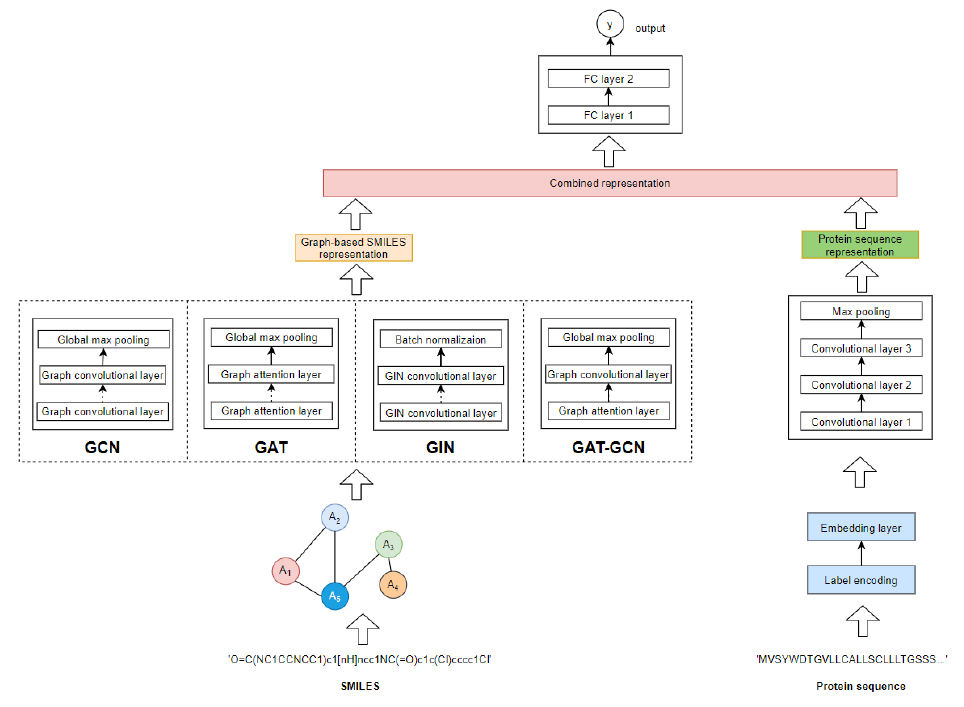

The code for GraphDTA is in `../apps/drug_target_interaction/graph_dta/`, we will redirect to this folder for later steps.

In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "..")))
os.chdir('../apps/drug_target_interaction/graph_dta/')
os.listdir(os.getcwd())

['data_gen.py',
 'data_preprocess.py',
 '__pycache__',
 'model.py',
 'utils.py',
 'train.py',
 'demos']

## Prepare dataset

Download the Davis dataset using `wget`.

In [3]:
# download and decompress the data
!wget "https://baidu-nlp.bj.bcebos.com/PaddleHelix%2Fdatasets%2Fdti_datasets%2Fdavis.tgz" --no-check-certificate
!tar -zxf "PaddleHelix%2Fdatasets%2Fdti_datasets%2Fdavis.tgz"
!ls "./davis/processed"

zsh:1: command not found: wget
tar: Error opening archive: Failed to open 'PaddleHelix%2Fdatasets%2Fdti_datasets%2Fdavis.tgz'
ls: ./davis/processed: No such file or directory


Suppose you have download the processed Davis dataset , please refer to the script `data_gen.py` for the implementation of `DTADataset` class, which is a stream dataset wrapper for [PGL](https://github.com/PaddlePaddle/PGL).

In [11]:
from data_gen import DTADataset

[INFO] 2020-12-16 16:24:46,122 [mp_reader.py:   23]:	ujson not install, fail back to use json instead


For the proteins sequences, there are two way to process them and get the inputs:
* cut or add padding to get protein sequences with a fixed length, i.e. setting a `max_protein_len` > 0.
* use the full protein sequence, i.e. setting a `max_protein_len` < 0.

In [12]:
train_data = './davis/processed/train'
test_data = './davis/processed/test'
max_protein_len = 1000  # set -1 to use full sequence

In [13]:
train_dataset = DTADataset(train_data, max_protein_len=max_protein_len)
test_dataset = DTADataset(test_data, max_protein_len=max_protein_len)

In [14]:
print(len(train_dataset), len(test_dataset))

25046 5010


## Create the model

In this tutorial, we take the GIN network as an example.

In [6]:
import paddle
import paddle.fluid as fluid
from model import DTAModel

paddle.enable_static()

`model_config` shows the hyperparameters for the whole network architecture. In particular, the `model_config['compound']` is the configuration for the GNN model of compounds, and `model_config['protein']` is the configuration for the sequence convolution-based protein presentation module.

In [7]:
lr = 0.0005                 # learning rate
model_config = {
    "compound": {
        "gnn_type": "gin",  # type of the GNN
        "dropout_rate": 0.2,# dropout rate for the GNN

        "embed_dim": 32,    # embedding size of atom type
        "layer_num": 5,     # number of GNN layers
        "hidden_size": 32,  # hidden size of GNN layers
        "output_dim": 128   # the dimension of representation of compound graph
    },

    "protein": {
        "max_protein_len": max_protein_len,  # set -1 to use full sequence
        "embed_dim": 128,   # embedding size of amino acid
        "num_filters": 32,  # num of filters of the sequence convolution
        "output_dim": 128   # the the dimension of representation of target protein
    },

    "dropout_rate": 0.2     # dropout rate for the affinity predictor
}

Create main program, start program, test program with static model `DTAModel` and Adam optimizer. For the details of `DTAModel`, please check the `model.py`. Basically, it implements the network architecutre showing in the above figure.

In [8]:
train_program, train_startup = fluid.Program(), fluid.Program()
with fluid.program_guard(train_program, train_startup):
    with fluid.unique_name.guard():
        model = DTAModel(model_config=model_config)
        model.train()
        test_program = train_program.clone(for_test=True)
        optimizer = fluid.optimizer.Adam(learning_rate=lr)
        optimizer.minimize(model.loss)

## Train and evaluate

In [9]:
import shutil
import numpy as np
from pgl.utils.data.dataloader import Dataloader

from data_gen import DTACollateFunc
from utils import concordance_index

In [10]:
max_epoch = 2                     # we use a small epoch number as demonstration
batch_size = 512                  # batch size for training
num_workers = 4                   # number of workers for the PGL dataloader
best_model = 'gin_best_model'     # directory to save the best model, i.e. with the minimum MSE
eval_txt = 'eval.txt'             # the text file to record the evaluation metric

Create a Paddle Executor. Note that we use GPU if there is any GPU card available.

In [11]:
has_cuda = len(fluid.cuda_places()) > 0
place = fluid.cuda_places()[0] if has_cuda else fluid.CPUPlace()
exe = fluid.Executor(place)

In [12]:
place

In the `train()` function, we create a `DTACollateFunc` which wraps a batch of processed into a batch of graph data `pgl.graph.MultiGraph` in PGL, then with the protein input data, it can help to organize the full feed dictionary. You can check the data preparation in the inference section to understand how it works.

In [13]:
def train(exe, train_program, model, train_dataset):
    collate_fn = DTACollateFunc(
        model.compound_graph_wrapper, 
        is_inference=False,
        label_name='Log10_Kd')
    data_loader = Dataloader(
        train_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        stream_shuffle_size=1000,
        collate_fn=collate_fn)
    
    list_loss = []
    for feed_dict in data_loader:
        train_loss, = exe.run(
            train_program, feed=feed_dict, fetch_list=[model.loss], return_numpy=False)
        list_loss.append(np.array(train_loss).mean())
    return np.mean(list_loss)

In the `evaluate()` function, we utilize MSE and Concordance Index (CI) to evaluate the model. However, computing the ranking-based metric CI is time-consuming, we introduce the prior smallest MSE (`best_mse`) to compare with current MSE, so we can avoid some unnecessary computation of CI.

In [14]:
def evaluate(exe, test_program, model, test_dataset, best_mse):
    collate_fn = DTACollateFunc(
        model.compound_graph_wrapper, 
        is_inference=False,
        label_name='Log10_Kd')
    data_loader = Dataloader(
        test_dataset,
        batch_size=batch_size,
        num_workers=1,
        collate_fn=collate_fn)
    
    total_n, processed = len(test_dataset), 0
    total_pred, total_label = [], []
    for idx, feed_dict in enumerate(data_loader):
        print('Evaluated {}/{}'.format(processed, total_n))
        pred, = exe.run(
            test_program, feed=feed_dict, fetch_list=[model.pred], return_numpy=False)
        total_pred.append(np.array(pred))
        total_label.append(feed_dict['label'])
        processed += total_pred[-1].shape[0]
        
    print('Evaluated {}/{}'.format(processed, total_n))
    total_pred = np.concatenate(total_pred, 0).flatten()
    total_label = np.concatenate(total_label, 0).flatten()
    mse = ((total_label - total_pred) ** 2).mean(axis=0)
    
    ci = None
    if mse < best_mse:
        ci = concordance_index(total_label, total_pred)
        
    return mse, ci

The training and evaluating pipline: for each epoch, evaluate the model, if it achieves a smaller MSE on the test dataset, save the best model and update the evaluation metrics.

In [15]:
exe.run(train_startup)
best_mse, best_ci, best_ep = np.inf, 0, 0
for epoch_id in range(1, max_epoch + 1):
    print('========== Epoch {} =========='.format(epoch_id))
    train_loss = train(exe, train_program, model, train_dataset)
    print('#Epoch: {}, Train loss: {}'.format(epoch_id, train_loss))
    mse, ci = evaluate(exe, test_program, model, test_dataset, best_mse)
    
    if mse < best_mse:
        best_mse, best_ci, best_ep = mse, ci, epoch_id
        if os.path.exists(best_model):
            shutil.rmtree(best_model)
            
        fluid.io.save_params(exe, best_model, train_program)
        metric = 'Epoch: {}, Best MSE: {}, Best CI: {}'.format(epoch_id, best_mse, best_ci)
        print(metric)
        with open(eval_txt, 'w') as f:
            f.write(metric)
    else:
        print('No improvement in epoch {}'.format(epoch_id))
        metric = open(os.path.join(eval_txt), 'r').read()
        print('===== Current best:\n{}'.format(metric))

========== Epoch 1 ==========
#Epoch: 1, Train loss: 2.0141453742980957
Evaluated 0/5010
Evaluated 512/5010
Evaluated 1024/5010
Evaluated 1536/5010
Evaluated 2048/5010
Evaluated 2560/5010
Evaluated 3072/5010
Evaluated 3584/5010
Evaluated 4096/5010
Evaluated 4608/5010
Evaluated 5010/5010
Epoch: 1, Best MSE: 1.3527016639709473, Best CI: 0.7702515670196785
========== Epoch 2 ==========
#Epoch: 2, Train loss: 0.7326631546020508
Evaluated 0/5010
Evaluated 512/5010
Evaluated 1024/5010
Evaluated 1536/5010
Evaluated 2048/5010
Evaluated 2560/5010
Evaluated 3072/5010
Evaluated 3584/5010
Evaluated 4096/5010
Evaluated 4608/5010
Evaluated 5010/5010
No improvement in epoch 2
===== Current best:
Epoch: 1, Best MSE: 1.3527016639709473, Best CI: 0.7702515670196785


In [16]:
os.listdir(os.getcwd())

['data_gen.py',
 'train.py',
 '__pycache__',
 'data_preprocess.py',
 'eval.txt',
 'demos',
 'model.py',
 'utils.py',
 'gin_best_model']

`eval.txt` and folder `gin_best_model` are saved after training.

## Inference

In [30]:
import pgl
from rdkit import Chem
from pahelix.utils.compound_tools import smiles_to_graph_data
from pahelix.utils.protein_tools import ProteinTokenizer

In [31]:
protein_example = 'MENKKKDKDKSDDRMARPSGRSGHNTRGTGSSSSGVLMVGPNFRVGKKIGCGNFGELRLGKNLYTNEYVAIKLEPMKSRAPQLHLEYRFYKQLGSGDGIPQVYYFGPCGKYNAMVLELLGPSLEDLFDLCDRTFSLKTVLMIAIQLISRMEYVHSKNLIYRDVKPENFLIGRPGNKTQQVIHIIDFGLAKEYIDPETKKHIPYREHKSLTGTARYMSINTHLGKEQSRRDDLEALGHMFMYFLRGSLPWQGLKADTLKERYQKIGDTKRATPIEVLCENFPEMATYLRYVRRLDFFEKPDYDYLRKLFTDLFDRKGYMFDYEYDWIGKQLPTPVGAVQQDPALSSNREAHQHRDKMQQSKNQSADHRAAWDSQQANPHHLRAHLAADRHGGSVQVVSSTNGELNTDDPTAGRSNAPITAPTEVEVMDETKCCCFFKRRKRKTIQRHK'
drug_example = 'CCN1C2=C(C=CC(=C2)OC)SC1=CC(=O)C'

In [32]:
len(protein_example)

447

In [33]:
isomeric_smiles = Chem.MolToSmiles(Chem.MolFromSmiles(drug_example), isomericSmiles=True)
compound_graph = smiles_to_graph_data(isomeric_smiles)

In [35]:
isomeric_smiles

'CCN1C(=CC(C)=O)Sc2ccc(OC)cc21'

Create a protein tokenizer which converts amino acid sequence into token IDs, ready for the embedding layer.

In [36]:
tokenizer = ProteinTokenizer()
protein_seq = tokenizer.gen_token_ids(protein_example)

In [37]:
len(protein_seq)

449

Add padding or cut the protein sequence when use fixed maximum protein length.

In [38]:
protein_seq = np.array(protein_seq, dtype=np.int64)
if max_protein_len > 0:
    protein_token_ids = np.zeros(max_protein_len) + ProteinTokenizer.padding_token_ID
    n = min(max_protein_len, len(protein_seq))
    protein_token_ids[:n] = np.array(protein_seq)[:n]
    protein_seq = protein_token_ids

In [39]:
len(protein_seq)

1000

Create the `feed_dict` for compound graph. Note that GraphDTA takes atom characteristics, such as number of directly-bonded neighbors (**degrees**), number of sigma electrons excluding electrons bonded to hydrogens (**Hs**), the number of hydrogens implicitly bonded to an atom (**implicit valence**), and whether it is **aromatic**. These four characteristics are treated as the numeric feature. Plus the other features used by Pretrain GNNs, we can represent the input graph using PGL API `pgl.graph.Graph` and `pgl.graph.MultiGraph`.

In [40]:
atom_numeric_feat = np.concatenate([
    compound_graph['atom_degrees'],
    compound_graph['atom_Hs'],
    compound_graph['atom_implicit_valence'],
    compound_graph['atom_is_aromatic'].reshape([-1, 1])
], axis=1).astype(np.float32)
g = pgl.graph.Graph(
    num_nodes = len(compound_graph['atom_type']),
    edges = compound_graph['edges'],
    node_feat = {
        'atom_type': compound_graph['atom_type'].reshape([-1, 1]),
        'chirality_tag': compound_graph['chirality_tag'].reshape([-1, 1]),
        'atom_numeric_feat': atom_numeric_feat
    },
    edge_feat = {
        'bond_type': compound_graph['bond_type'].reshape([-1, 1]),
        'bond_direction': compound_graph['bond_direction'].reshape([-1, 1])
    })
join_graph = pgl.graph.MultiGraph([g])

In [41]:
feed_dict = model.compound_graph_wrapper.to_feed(join_graph)

Update the `feed_dict` for protein sequence. Notice that the `label` input is just a placeholder, otherwise the static graph won't work.

In [48]:
protein_token = [protein_seq]
protein_length = [0, protein_seq.size]
feed_dict['protein_token'] = np.concatenate(protein_token).reshape([-1, 1]).astype('int64')
feed_dict['protein_token_lod'] = np.add.accumulate(protein_length).reshape([1, -1]).astype('int32')
feed_dict['label'] = np.array([[1.0]]).astype(np.float32)  # just a placeholder

In [51]:
pred, = exe.run(test_program, feed=feed_dict, fetch_list=[model.pred], return_numpy=True)

Predicted Kd value:

In [53]:
pred[0][0]

4.067789

You can setup the customized `protein_example` and `drug_example` to infer other drug and target protein pairs.